In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from dataset.sentinel import *
from models.lstm_ae import *
import torch
import random
from pathlib import Path
from config import *
from utils import *
from lstm_utils import *

import numpy as np
import platform
import json

architecture='lstm_ae'

In [2]:
exp_dict = exp_name_folders(path =esa_exploration, architecture='lstm_ae')
for k in exp_dict.keys():
    print('num selection:{} - exp name:{}'.format(k, exp_dict[k]))

num selection:0 - exp name:4_wheel_system_extended_params_sl_16
num selection:1 - exp name:4_wheel_system_extended_params_sl_100
num selection:2 - exp name:4_wheel_system_lstm_ae_sl_30_run1
num selection:3 - exp name:third_wheel_extended_params_sl_100
num selection:4 - exp name:third_wheel_lstm_extended_params_sl_30_run_1


In [17]:
select_exp = '1'
added_path = exp_dict[select_exp]
model_results_path = esa_exploration + '{}/{}'.format(architecture, added_path)
print('selected experiment:', added_path)

selected experiment: 4_wheel_system_extended_params_sl_100


In [18]:
files = os.listdir(model_results_path)
model_list, summary = find_models(files, model_results_path)

summary path: /srv/penny/FIORIRE/time_series_anomaly_detection/model_results/esa_exploration/lstm_ae/4_wheel_system_extended_params_sl_100/summary.csv


In [19]:
summary.reset_index().head(10)

,index,Unnamed: 0,name,parameters_number,train_loss,val_loss
0,29,14,"trainLSTMAE_56c65_00019_19_batch_size=100,embe...",160352,0.029438,0.033306
1,28,26,"trainLSTMAE_56c65_00007_7_batch_size=500,embed...",160352,0.029838,0.033837
2,27,18,"trainLSTMAE_56c65_00014_14_batch_size=500,embe...",157132,0.031271,0.035181
3,26,7,"trainLSTMAE_56c65_00011_11_batch_size=100,embe...",157132,0.034482,0.037702
4,25,10,"trainLSTMAE_56c65_00029_29_batch_size=100,embe...",157132,0.034482,0.037702
5,24,29,"trainLSTMAE_56c65_00002_2_batch_size=500,embed...",153912,0.056993,0.060678
6,23,15,"trainLSTMAE_56c65_00000_0_batch_size=1000,embe...",153912,0.085591,0.091593
7,22,27,"trainLSTMAE_56c65_00015_15_batch_size=500,embe...",153912,0.136639,0.138373
8,21,11,"trainLSTMAE_56c65_00003_3_batch_size=500,embed...",160352,0.222005,0.224765
9,20,13,"trainLSTMAE_56c65_00022_22_batch_size=500,embe...",160352,0.222005,0.224765


In [20]:
rank = 0
model_name_path = select_by_rank(rank, model_results_path, summary)
model_name = summary.name.iloc[rank]
f = open(os.path.join(model_results_path, '/'.join(model_name_path.split('/')[:-2]), 'params.json'))
print('hyper-parameters')
print(json.load(f))

hyper-parameters
{'batch_size': 100, 'embedding_dim': 32, 'epochs': 200, 'latent_dim': 80, 'lr': 0.0006, 'lr_patience': 5, 'n_layers_cell_1': 2, 'n_layers_cell_2': 2, 'seq_in_length': 100}


In [21]:
try:
    sm = str(torch.cuda.get_device_capability())
    sm = ''.join((sm.strip('()').split(',')[0], sm.strip('()').split(',')[1])).replace(' ', '')
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda and sm in torch.cuda.get_arch_list() else "cpu")
except:
    device='cpu'

In [22]:
checkpoint  = torch.load(os.path.join(model_results_path, model_name_path), map_location=device)
params_conf = checkpoint['param_conf']
cfg = checkpoint['cfg']

In [23]:
dataset_name = os.path.join(data_path.strip('..'), "all_2016-2018_clean_std_4s.pkl")
transform = None
df_train, df_test, train_iter, test_iter = \
read_dataset(dataset_name=dataset_name, scaled=params_conf['scaled'], cols=checkpoint['cfg']['dataset']['columns'],
columns_subset=cfg['dataset']['columns_subset'], dataset_subset=cfg['dataset']['dataset_subset']
, sequence_length=params_conf['sequence_length'],out_window=params_conf['sequence_length'], 
train_val_split=cfg['dataset']['train_val_split'], batch_size=params_conf['batch_size'], transform=transform)    

In [24]:
num_batch=10
print('time horizon {}'.format(num_batch*params_conf['sequence_length']))
x, shift = unrolling_batches(num_batch, test_iter, sequence_length=params_conf['sequence_length']
                             , cols=cfg['dataset']['columns'])

time horizon 1000
random shift 159931


In [25]:
try:
    model = LSTM_AE(seq_in=params_conf['sequence_length'],seq_out=params_conf['out_window'],
            n_features=params_conf['n_features'], output_size=params_conf['output_size'],
            embedding_dim=params_conf['embedding_dim'], latent_dim=params_conf['latent_dim'],
                    n_layers_1=params_conf['n_layers_1'], n_layers_2=params_conf['n_layers_2'])
except:
    model = LSTM_AE(seq_in=params_conf['sequence_length'],seq_out=params_conf['out_window'],
        n_features=params_conf['n_features'], output_size=params_conf['output_size'],
        embedding_dim=params_conf['embedding_dim'], latent_dim=params_conf['latent_dim'],
                n_layers_1=params_conf['n_layers'], n_layers_2=params_conf['n_layers'])
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device).eval()
print('parameters number', count_parameters(model))

LSTM_AE(
  (encoder): Encoder(
    (LSTMenc): LSTM(16, 64, num_layers=2, batch_first=True)
    (LSTM1): LSTM(64, 32, num_layers=2, batch_first=True)
    (enc): Linear(in_features=32, out_features=80, bias=True)
  )
  (decoder): Decoder(
    (LSTMdec): LSTM(80, 32, num_layers=2, batch_first=True)
    (LSTM1): LSTM(32, 64, num_layers=2, batch_first=True)
    (fc): Linear(in_features=64, out_features=16, bias=True)
  )
)
parameters number 160352


In [26]:
x, enc, yo = model(x.to(device))

In [27]:
path = './figure_results/{}/{}/'.format(model_results_path, shift)
par_nums=count_parameters(model)
print(path)
save = False

./figure_results//srv/penny/FIORIRE/time_series_anomaly_detection/model_results/esa_exploration/lstm_ae/4_wheel_system_extended_params_sl_100/159931/


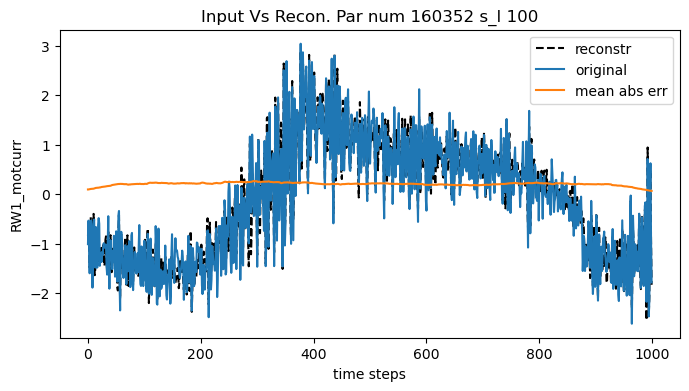

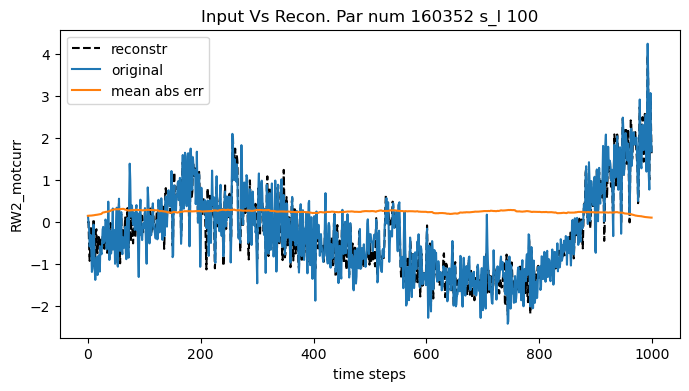

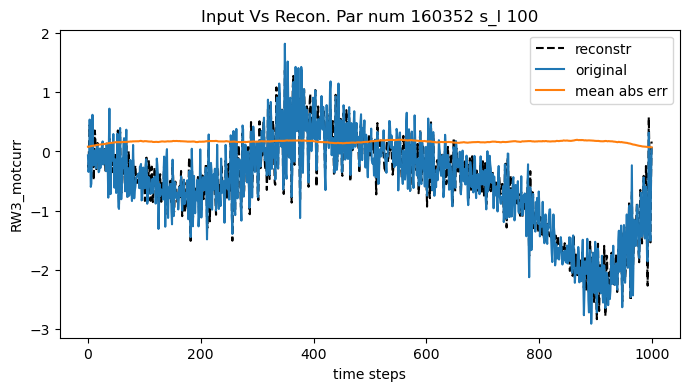

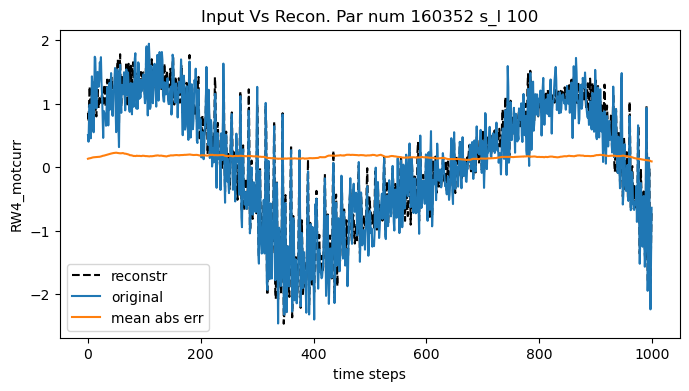

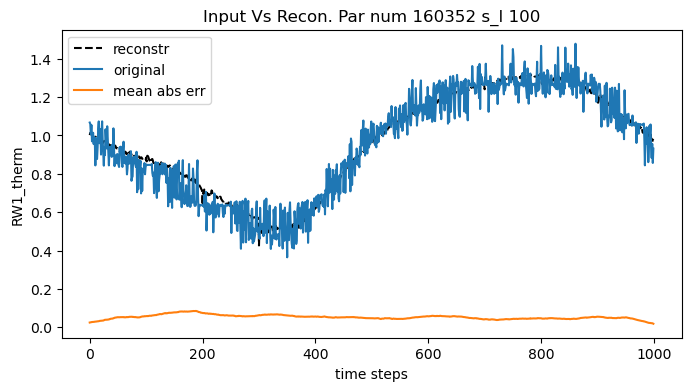

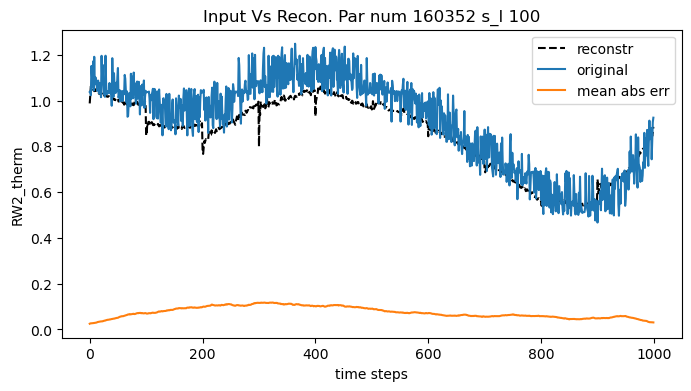

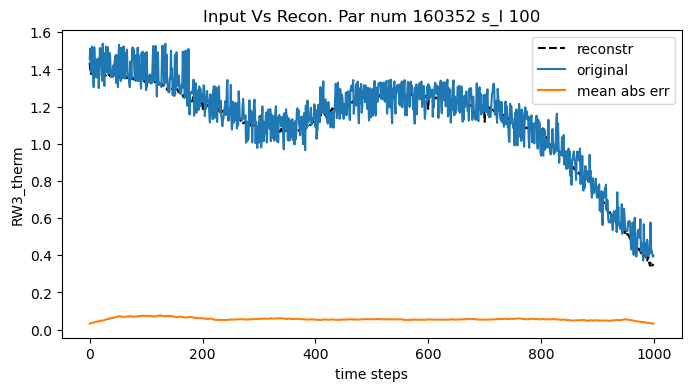

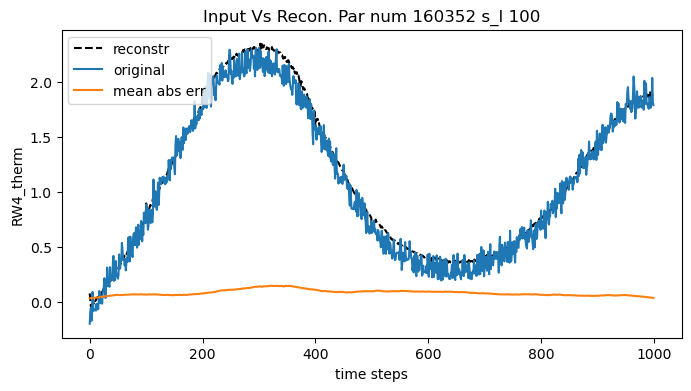

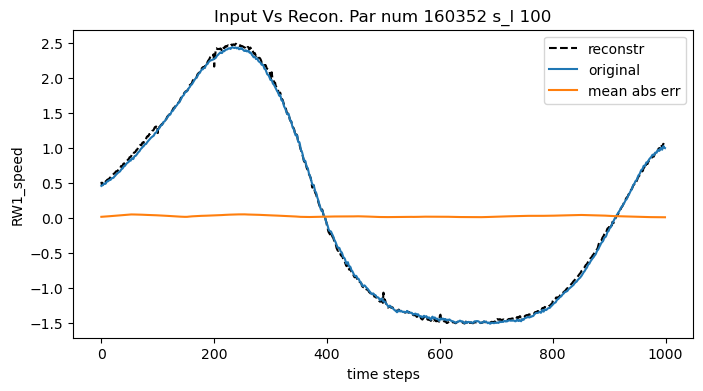

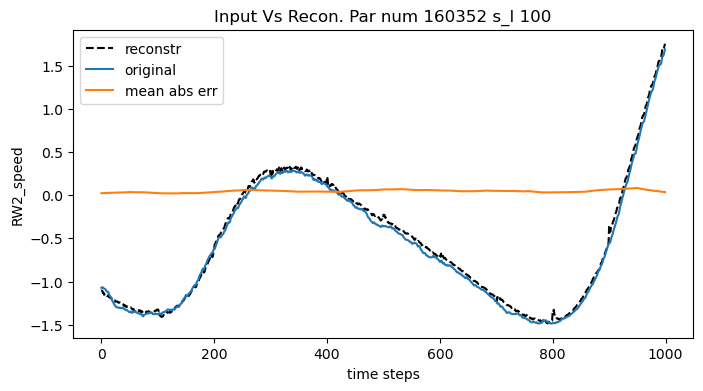

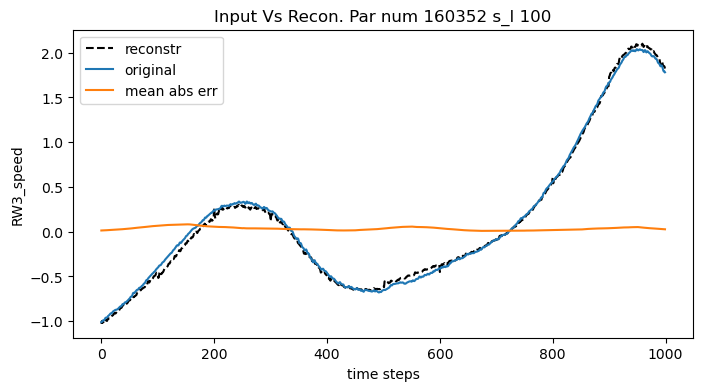

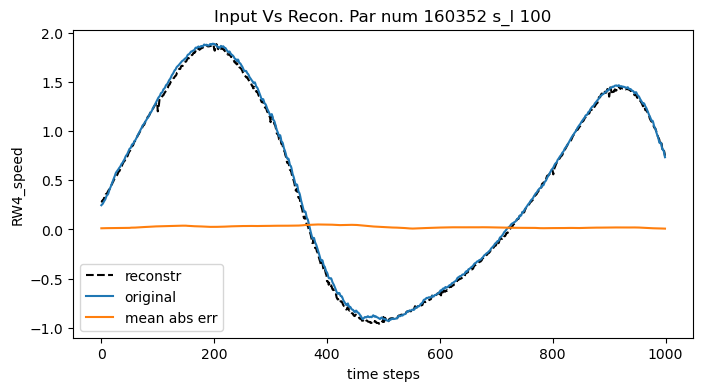

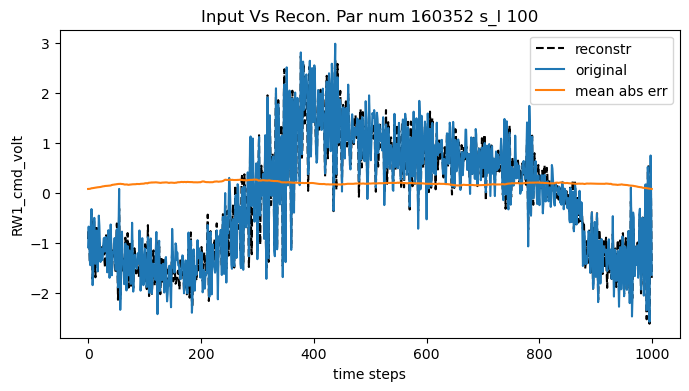

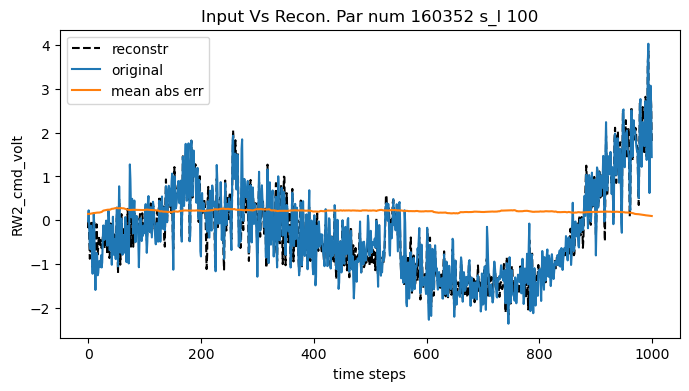

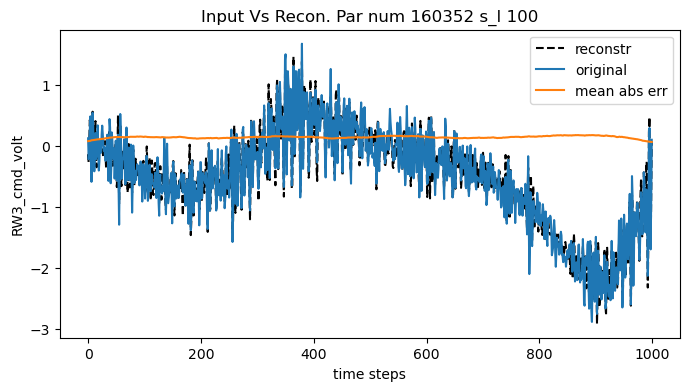

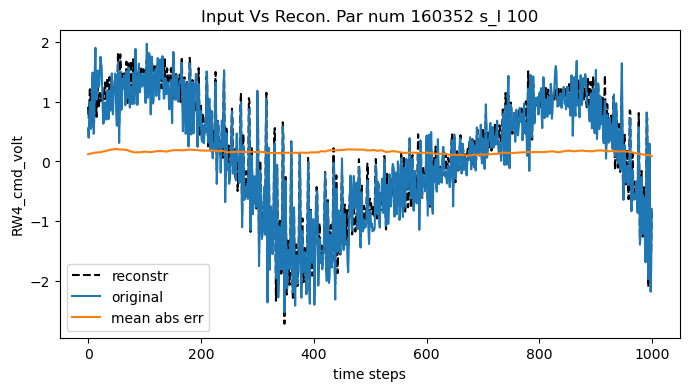

In [29]:
show_results(x,yo,checkpoint['cfg']['dataset']['columns'],
    model_name,params_conf,
    par_nums,shift,num_batch,
    architecture='lstm_ae',
    save=False)